In [1]:
# load std libs
from os import scandir
from datetime import datetime

# load third-party libraries
from tqdm import tqdm
import numpy as np
import pandas as pd
import tensorflow as tf
from IPython.display import display
from matplotlib import pyplot as plt
%matplotlib inline

# load source code
from src.image_loader import load_images
from src.utils import one_hot, shuffle_and_split, shuffle, get_batch
from src.alexnet import AlexNet

# initialization code
np.random.seed(42)
IMG_SIZE = 224

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:962: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:962: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### EDA
Inspect the data a bit. Make sure you've downloaded the training data, unzipped it, and placed it in the `./data/train/raw` directory.

In [2]:
image_dimensions = !find ./data/train/raw -type f -name '*.png' -exec identify -format '%w %h\n' {} +

In [8]:
image_dims_df = pd.DataFrame((map(int, dims.split(' ')) for dims in image_dimensions), columns=("w", "h"))
image_dims_df["ratio"] = image_dims_df.apply(lambda row: row.w / row.h, axis=1)
display(image_dims_df.head())

,w,h,ratio
0,531,531,1.0
1,352,352,1.0
2,373,373,1.0
3,187,187,1.0
4,210,210,1.0


# of images: 4750 

                 w            h        ratio
count  4750.000000  4750.000000  4750.000000
mean    371.465895   370.730105     1.000364
std     323.275012   318.649607     0.009373
min      49.000000    49.000000     0.943368
25%     140.000000   140.000000     1.000000
50%     266.500000   266.500000     1.000000
75%     507.750000   507.000000     1.000000
max    3991.000000  3457.000000     1.332083


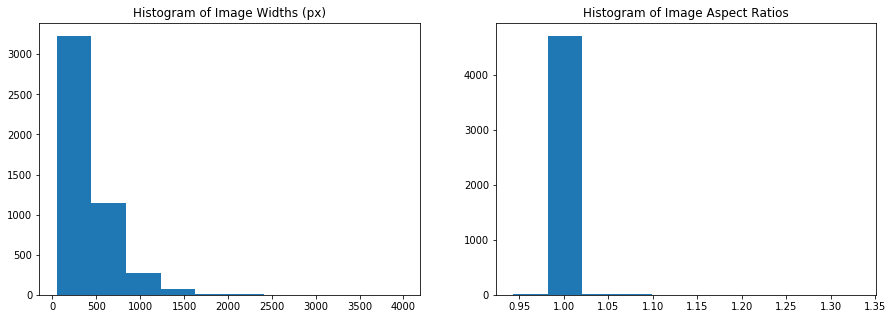

In [42]:
print("# of images: %d" % len(image_dims_df), "\n")

print(image_dims_df.describe())

fig = plt.figure(figsize=(15, 5))
sub1 = fig.add_subplot(1, 2, 1)
sub1.hist(image_dims_df.w)
sub1.set_title("Histogram of Image Widths (px)")
sub2 = fig.add_subplot(1, 2, 2)
sub2.hist(image_dims_df.ratio)
sub2.set_title("Histogram of Image Aspect Ratios")
None

### Resize images
Run this once to resize the images and save to disk. This takes a few minutes.

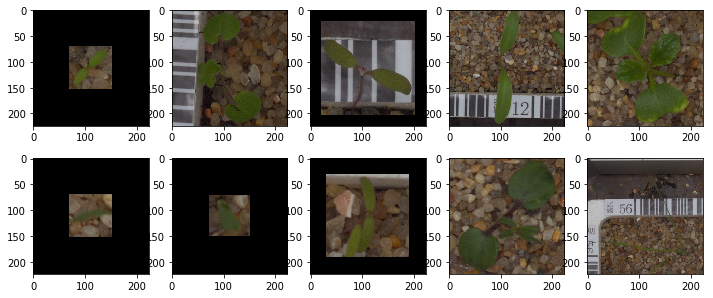

In [2]:
train_imgs = load_images("./data/train/raw/*/*.png",
                         desired_size=IMG_SIZE,
                         scale_down=True,
                         pad_up=True,
                         write_to="./data/train/resized",
                         preserve_dir_tree_at="./data/train/raw")

fig = plt.figure(figsize=(12, 5))
for i in range(10):
    sub = fig.add_subplot(2, 5, i + 1)
    rand_i = np.random.randint(0, len(train_imgs))
    sub.imshow(train_imgs[rand_i])

del train_imgs

In [3]:
class_names = [f.name for f in scandir("./data/train/raw") if f.is_dir()]
print(class_names)

class_name_to_idx = {}
class_idx_to_name = {}
train_imgs_ord = []
train_labels_ord = []

for i, name in enumerate(class_names):
    class_name_to_idx[name] = i
    class_idx_to_name[i] = name
    imgs = load_images("./data/train/resized/%s/*.png" % name, desired_size=IMG_SIZE, scale_down=True, pad_up=True)
    train_imgs_ord.extend(imgs)
    train_labels_ord.extend([i] * len(imgs))

train_imgs_ord = np.array(train_imgs_ord)
print(train_imgs_ord.shape)
train_labels_ord = one_hot(train_labels_ord)
print(train_labels_ord.shape)

['Fat Hen', 'Charlock', 'Sugar beet', 'Maize', 'Scentless Mayweed', 'Loose Silky-bent', 'Black-grass', 'Common wheat', 'Cleavers', 'Shepherds Purse', 'Common Chickweed', 'Small-flowered Cranesbill']
(4750, 224, 224, 3)
(4750, 12)


In [6]:
train_data, train_labels, dev_data, dev_labels = shuffle_and_split(train_imgs_ord, train_labels_ord, dev_fraction=0.15)
mirror_train_data = train_data[:, :, ::-1, :]
train_data = np.concatenate((train_data, mirror_train_data))
train_labels = np.tile(train_labels, (2, 1))
print(train_data.shape)
print(train_labels.shape)
print(dev_data.shape)
print(dev_labels.shape)

(8076, 224, 224, 3)
(8076, 12)
(712, 224, 224, 3)
(712, 12)


In [7]:
learning_rate = 8e-5

num_epochs = 20
batch_size = 128

dropout_rate = 0.5
num_classes = train_labels.shape[1]

# how often to write tf.summary to disk
display_step = 5

In [8]:
tf.reset_default_graph()
X = tf.placeholder(tf.float32, shape=(batch_size, IMG_SIZE, IMG_SIZE, 3), name="X")
Y = tf.placeholder(tf.float32, shape=(batch_size, num_classes), name="Y")
dropout = tf.placeholder(tf.float32, name="dropout_rate")

model = AlexNet(X, dropout, num_classes)
model.logits.get_shape()

loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=model.logits, labels=Y))

with tf.name_scope("train"):
    optimizer = tf.train.AdamOptimizer(learning_rate)
    optimization_op = optimizer.minimize(loss)

tf.summary.scalar('loss', loss)

with tf.name_scope("accuracy"):
    predictions = tf.argmax(model.logits, axis=1)
    correct_predictions = tf.equal(predictions, tf.argmax(Y, axis=1))
    accuracy = tf.reduce_mean(tf.cast(correct_predictions, tf.float32))

tf.summary.scalar('training_accuracy', accuracy)

merged_summary = tf.summary.merge_all()
writer = tf.summary.FileWriter("./tensorboard3")
saver = tf.train.Saver()

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.



In [ ]:
training_batches_per_epoch = int(np.floor(train_data.shape[0] / batch_size))
dev_batches_per_epoch = int(np.floor(dev_data.shape[0] / batch_size))

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    writer.add_graph(sess.graph)

    for epoch in range(num_epochs):
        print("{} epoch number: {}".format(datetime.now(), epoch + 1))
        train_data, train_labels = shuffle(train_data, train_labels)
        
        for step in tqdm(range(training_batches_per_epoch)):
            x_batch, y_batch = get_batch(train_data, train_labels, step, batch_size)
            sess.run(optimization_op, feed_dict={X: x_batch, Y: y_batch, dropout: dropout_rate })

            # every so often, report the progress of our loss and training accuracy
            if step % display_step == 0:
                summ = sess.run(merged_summary, feed_dict={X: x_batch, Y: y_batch, dropout: 0 })
                writer.add_summary(summ, epoch * training_batches_per_epoch + step)
                writer.flush()

        dev_acc = 0
        dev_count = 0
        for step in range(dev_batches_per_epoch):
            x_batch, y_batch = get_batch(dev_data, dev_labels, step, batch_size)
            acc = sess.run(accuracy, feed_dict={X: x_batch, Y: y_batch, dropout: 0 })
            dev_acc += acc
            dev_count += 1

        print("dev accuracy = {:.4f}".format(dev_acc / dev_count))
    
    # save the model to disk so we can load it up later for use by `./eval.py`
    saver.save(sess, "./tensorflow-ckpt/model.ckpt")

2018-03-03 06:51:45.195586 epoch number: 1


100%|██████████| 63/63 [00:10<00:00,  6.03it/s]


dev accuracy = 0.3156
2018-03-03 06:51:59.360698 epoch number: 2


100%|██████████| 63/63 [00:08<00:00,  7.04it/s]


dev accuracy = 0.4250
2018-03-03 06:52:12.021967 epoch number: 3


100%|██████████| 63/63 [00:08<00:00,  7.05it/s]


dev accuracy = 0.5375
2018-03-03 06:52:24.673266 epoch number: 4


100%|██████████| 63/63 [00:08<00:00,  7.04it/s]


dev accuracy = 0.6141
2018-03-03 06:52:37.412681 epoch number: 5


100%|██████████| 63/63 [00:08<00:00,  7.03it/s]


dev accuracy = 0.6719
2018-03-03 06:52:50.138674 epoch number: 6


100%|██████████| 63/63 [00:09<00:00,  7.00it/s]


dev accuracy = 0.7484
2018-03-03 06:53:02.849139 epoch number: 7


100%|██████████| 63/63 [00:09<00:00,  6.89it/s]


dev accuracy = 0.7672
2018-03-03 06:53:15.690072 epoch number: 8


100%|██████████| 63/63 [00:09<00:00,  6.83it/s]


dev accuracy = 0.7469
2018-03-03 06:53:28.615909 epoch number: 9


100%|██████████| 63/63 [00:09<00:00,  6.88it/s]


dev accuracy = 0.7250
2018-03-03 06:53:41.574902 epoch number: 10


100%|██████████| 63/63 [00:09<00:00,  6.86it/s]


dev accuracy = 0.7172
2018-03-03 06:53:54.562011 epoch number: 11


 22%|██▏       | 14/63 [00:02<00:07,  6.82it/s]

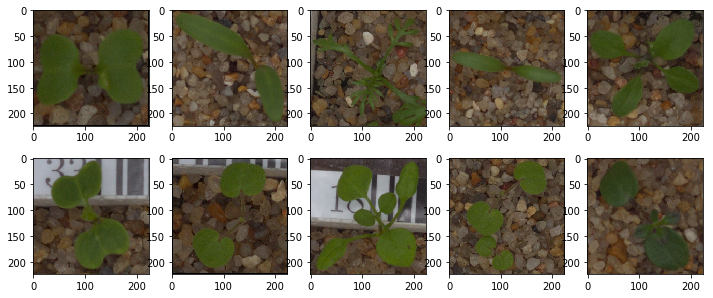

In [13]:
test_imgs = load_images("./data/test/raw/*.png",
                         desired_size=IMG_SIZE,
                         scale_down=True,
                         pad_up=True,
                         write_to="./data/test/resized")

fig = plt.figure(figsize=(12, 5))
for i in range(10):
    sub = fig.add_subplot(2, 5, i + 1)
    rand_i = np.random.randint(0, len(test_imgs))
    sub.imshow(test_imgs[rand_i])

del test_imgs

In [ ]:
test_imgs, file_names = load_images("./data/test/resized/*.png", desired_size=IMG_SIZE, scale_down=True, pad_up=True, file_names=True)

In [ ]:
# create a new graph which differs slightly from the previous
inference_graph = tf.Graph()
with inference_graph.as_default():
    # the LRN layer throws an error with too many images at once, so we'll limit to 10,000
    X = tf.placeholder(tf.float32, shape=(len(test_imgs), IMG_SIZE, IMG_SIZE, 3), name="X")
    dropout = tf.constant(0)

    model = AlexNet(X, dropout, num_classes)
    
    predictions = tf.argmax(model.logits, axis=1)
    
    saver = tf.train.Saver()
    
    # restore the model in this graph and see which predications were wrong
    with tf.Session() as sess:
        saver.restore(sess, "./tensorflow-ckpt/model.ckpt")
        test_predictions = sess.run(predictions, feed_dict={X: test_imgs})
        prediction_df = pd.DataFrame(data={"file": file_names, "species": np.array(class_names)[test_predictions]})
        display(prediction_df.head())
        prediction_df.to_csv("./test_predictions.csv", index=False)